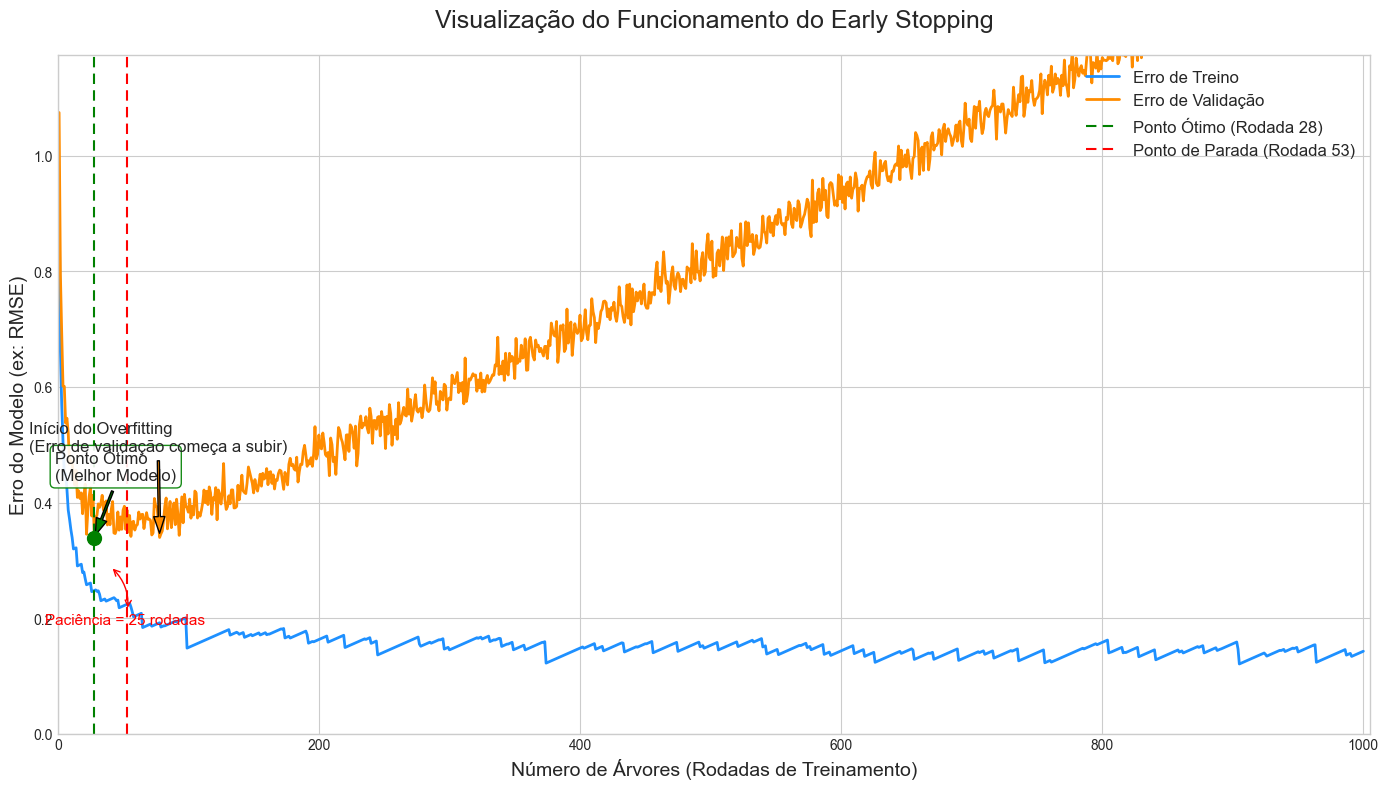

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

# Define um estilo visual agradável para o gráfico
style.use('seaborn-v0_8-whitegrid')

# --- 1. Geração de Dados Sintéticos ---
# Criamos dados que simulam o comportamento típico das curvas de erro.

# Eixo X: Número de rodadas de treinamento (árvores)
n_rounds = 1000
rounds = np.arange(1, n_rounds + 1)

# Eixo Y: Erro de Treino (geralmente sempre diminui)
# Usamos uma função de decaimento com um pouco de ruído aleatório.
noise_train = np.random.normal(0, 0.015, n_rounds)
train_error = 0.8 / (rounds**0.6) + 0.15 + noise_train
# Garante que o erro não seja negativo e que tenha uma tendência de queda
train_error = np.maximum(train_error, 0.1)
for i in range(1, n_rounds):
    train_error[i] = min(train_error[i], train_error[i-1] + 0.001)


# Eixo Y: Erro de Validação (diminui e depois sobe, indicando overfitting)
# Usamos uma combinação de decaimento e um termo linear para fazê-lo subir.
noise_val = np.random.normal(0, 0.02, n_rounds)
validation_error = 0.9 / (rounds**0.5) + 0.0012 * rounds + 0.18 + noise_val


# --- 2. Encontrando os Pontos-Chave para Anotação ---

# Encontra o ponto ótimo (a rodada com o menor erro de validação)
optimal_round_idx = np.argmin(validation_error)
optimal_round = rounds[optimal_round_idx]
min_validation_error = validation_error[optimal_round_idx]

# Simula o 'early_stopping_rounds' (paciência)
patience = 25
stop_round = optimal_round + patience
# Garante que o ponto de parada não exceda o número total de rodadas
stop_round = min(stop_round, n_rounds)


# --- 3. Geração do Gráfico ---

plt.figure(figsize=(14, 8))

# Plota as duas curvas de erro
plt.plot(rounds, train_error, label='Erro de Treino', color='dodgerblue', linewidth=2)
plt.plot(rounds, validation_error, label='Erro de Validação', color='darkorange', linewidth=2)

# Adiciona linhas verticais e anotações para destacar os pontos importantes
plt.axvline(x=optimal_round, color='green', linestyle='--', dashes=(5, 3), label=f'Ponto Ótimo (Rodada {optimal_round})')
plt.axvline(x=stop_round, color='red', linestyle='--', dashes=(5, 3), label=f'Ponto de Parada (Rodada {stop_round})')

# Marca o ponto ótimo com um ponto verde
plt.scatter(optimal_round, min_validation_error, color='green', s=100, zorder=5)

# Anotações no gráfico para explicar o que está acontecendo
plt.annotate(
    'Ponto Ótimo\n(Melhor Modelo)',
    xy=(optimal_round, min_validation_error),
    xytext=(optimal_round - 30, min_validation_error + 0.1),
    arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", lw=1, alpha=0.9)
)

plt.annotate(
    'Início do Overfitting\n(Erro de validação começa a subir)',
    xy=(optimal_round + 50, validation_error[optimal_round_idx + 50]),
    xytext=(optimal_round - 50, validation_error[optimal_round_idx + 50] + 0.15),
    arrowprops=dict(facecolor='darkorange', shrink=0.05, width=1.5, headwidth=8),
    fontsize=12
)

plt.annotate(
    f'Paciência = {patience} rodadas',
    xy=(optimal_round + patience/2, min_validation_error - 0.05),
    xytext=(optimal_round + patience/2 - 50, min_validation_error - 0.15),
    arrowprops=dict(arrowstyle="<->", connectionstyle="arc3,rad=0.3", ec='red'),
    fontsize=11,
    color='red'
)


# Configurações finais do gráfico
plt.title('Visualização do Funcionamento do Early Stopping', fontsize=18, pad=20)
plt.xlabel('Número de Árvores (Rodadas de Treinamento)', fontsize=14)
plt.ylabel('Erro do Modelo (ex: RMSE)', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.ylim(0, max(validation_error[0], train_error[0]) + 0.1) # Ajusta o limite do eixo Y
plt.xlim(0, n_rounds + 5) # Ajusta o limite do eixo X
plt.tight_layout()

# Exibe o gráfico
plt.show()

Carregando e preparando os dados...
Dados preparados e divididos.

Definindo o pipeline de Stacking...
Pipeline definido.

Iniciando o treinamento do modelo de Stacking... Isso pode ser demorado.
Treinamento do Stacking concluído em 30.10 segundos.

--- Resultados do Modelo de Stacking ---
MAE (Mean Absolute Error): 0.0728
RMSE (Root Mean Squared Error): 0.0877


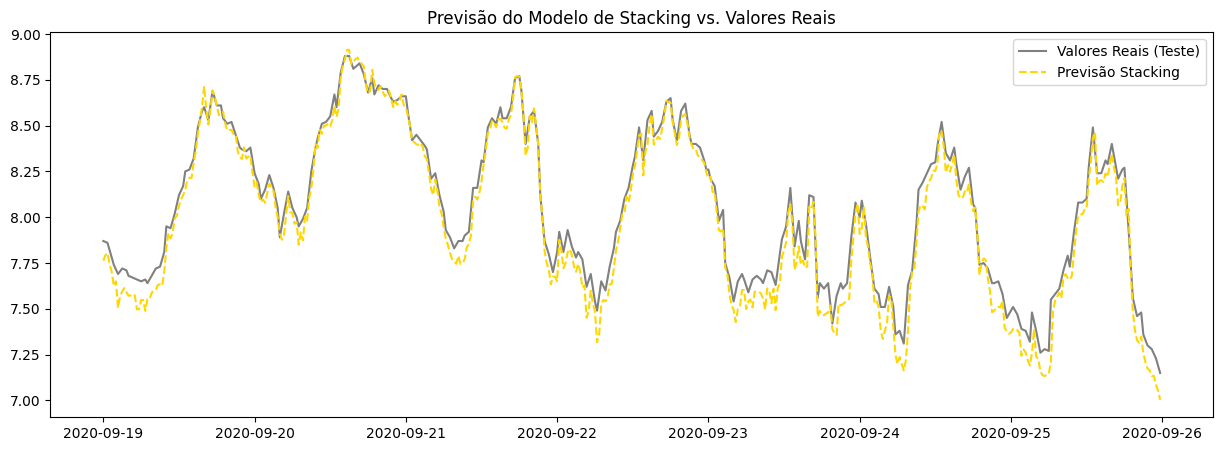

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold # <-- MUDANÇA AQUI
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

df_featured = create_champion_features(df, target_variable='ph')

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
print("Dados preparados e divididos.")

# --- 2. Definição do Pipeline de Stacking ---
print("\nDefinindo o pipeline de Stacking...")

estimators = [
    ('RandomForest', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
    ('LightGBM', lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42,
                                  learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0)),
    ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, n_jobs=-1, seed=42,
                                 learning_rate=0.05, max_depth=7, subsample=1.0, colsample_bytree=1.0))
]

meta_model = Ridge()

# #############################################################################
# CORREÇÃO APLICADA AQUI: Trocamos TimeSeriesSplit por KFold(shuffle=False)
# #############################################################################
cv_stacking = KFold(n_splits=5, shuffle=False)

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=cv_stacking,
    n_jobs=-1,
    verbose=2
)
print("Pipeline definido.")

# --- 3. Treinamento e Avaliação do Modelo de Stacking ---
print("\nIniciando o treinamento do modelo de Stacking... Isso pode ser demorado.")
start_time = time.time()

stacking_model.fit(X_train, y_train)

end_time = time.time()
print(f"Treinamento do Stacking concluído em {end_time - start_time:.2f} segundos.")

# --- Previsão e Avaliação ---
stacking_forecast = stacking_model.predict(X_test)

mae_stacking = mean_absolute_error(y_test, stacking_forecast)
rmse_stacking = np.sqrt(mean_squared_error(y_test, stacking_forecast))

print("\n--- Resultados do Modelo de Stacking ---")
print(f"MAE (Mean Absolute Error): {mae_stacking:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_stacking:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, stacking_forecast, label='Previsão Stacking', color='gold', linestyle='--')
ax.set_title('Previsão do Modelo de Stacking vs. Valores Reais')
ax.legend()
plt.show()

Carregando e preparando os dados...
Dados preparados e divididos.

Treinando os modelos base ('Diretores') individualmente...
  -> Treinando RandomForest...
     MAE (RandomForest): 0.0179
  -> Treinando LightGBM...
     MAE (LightGBM): 0.0230
  -> Treinando XGBoost...
     MAE (XGBoost): 0.0230

Iniciando o treinamento do modelo de Stacking ('Presidente')...
     MAE (Stacking - Presidente): 0.0728

Gerando gráficos comparativos...


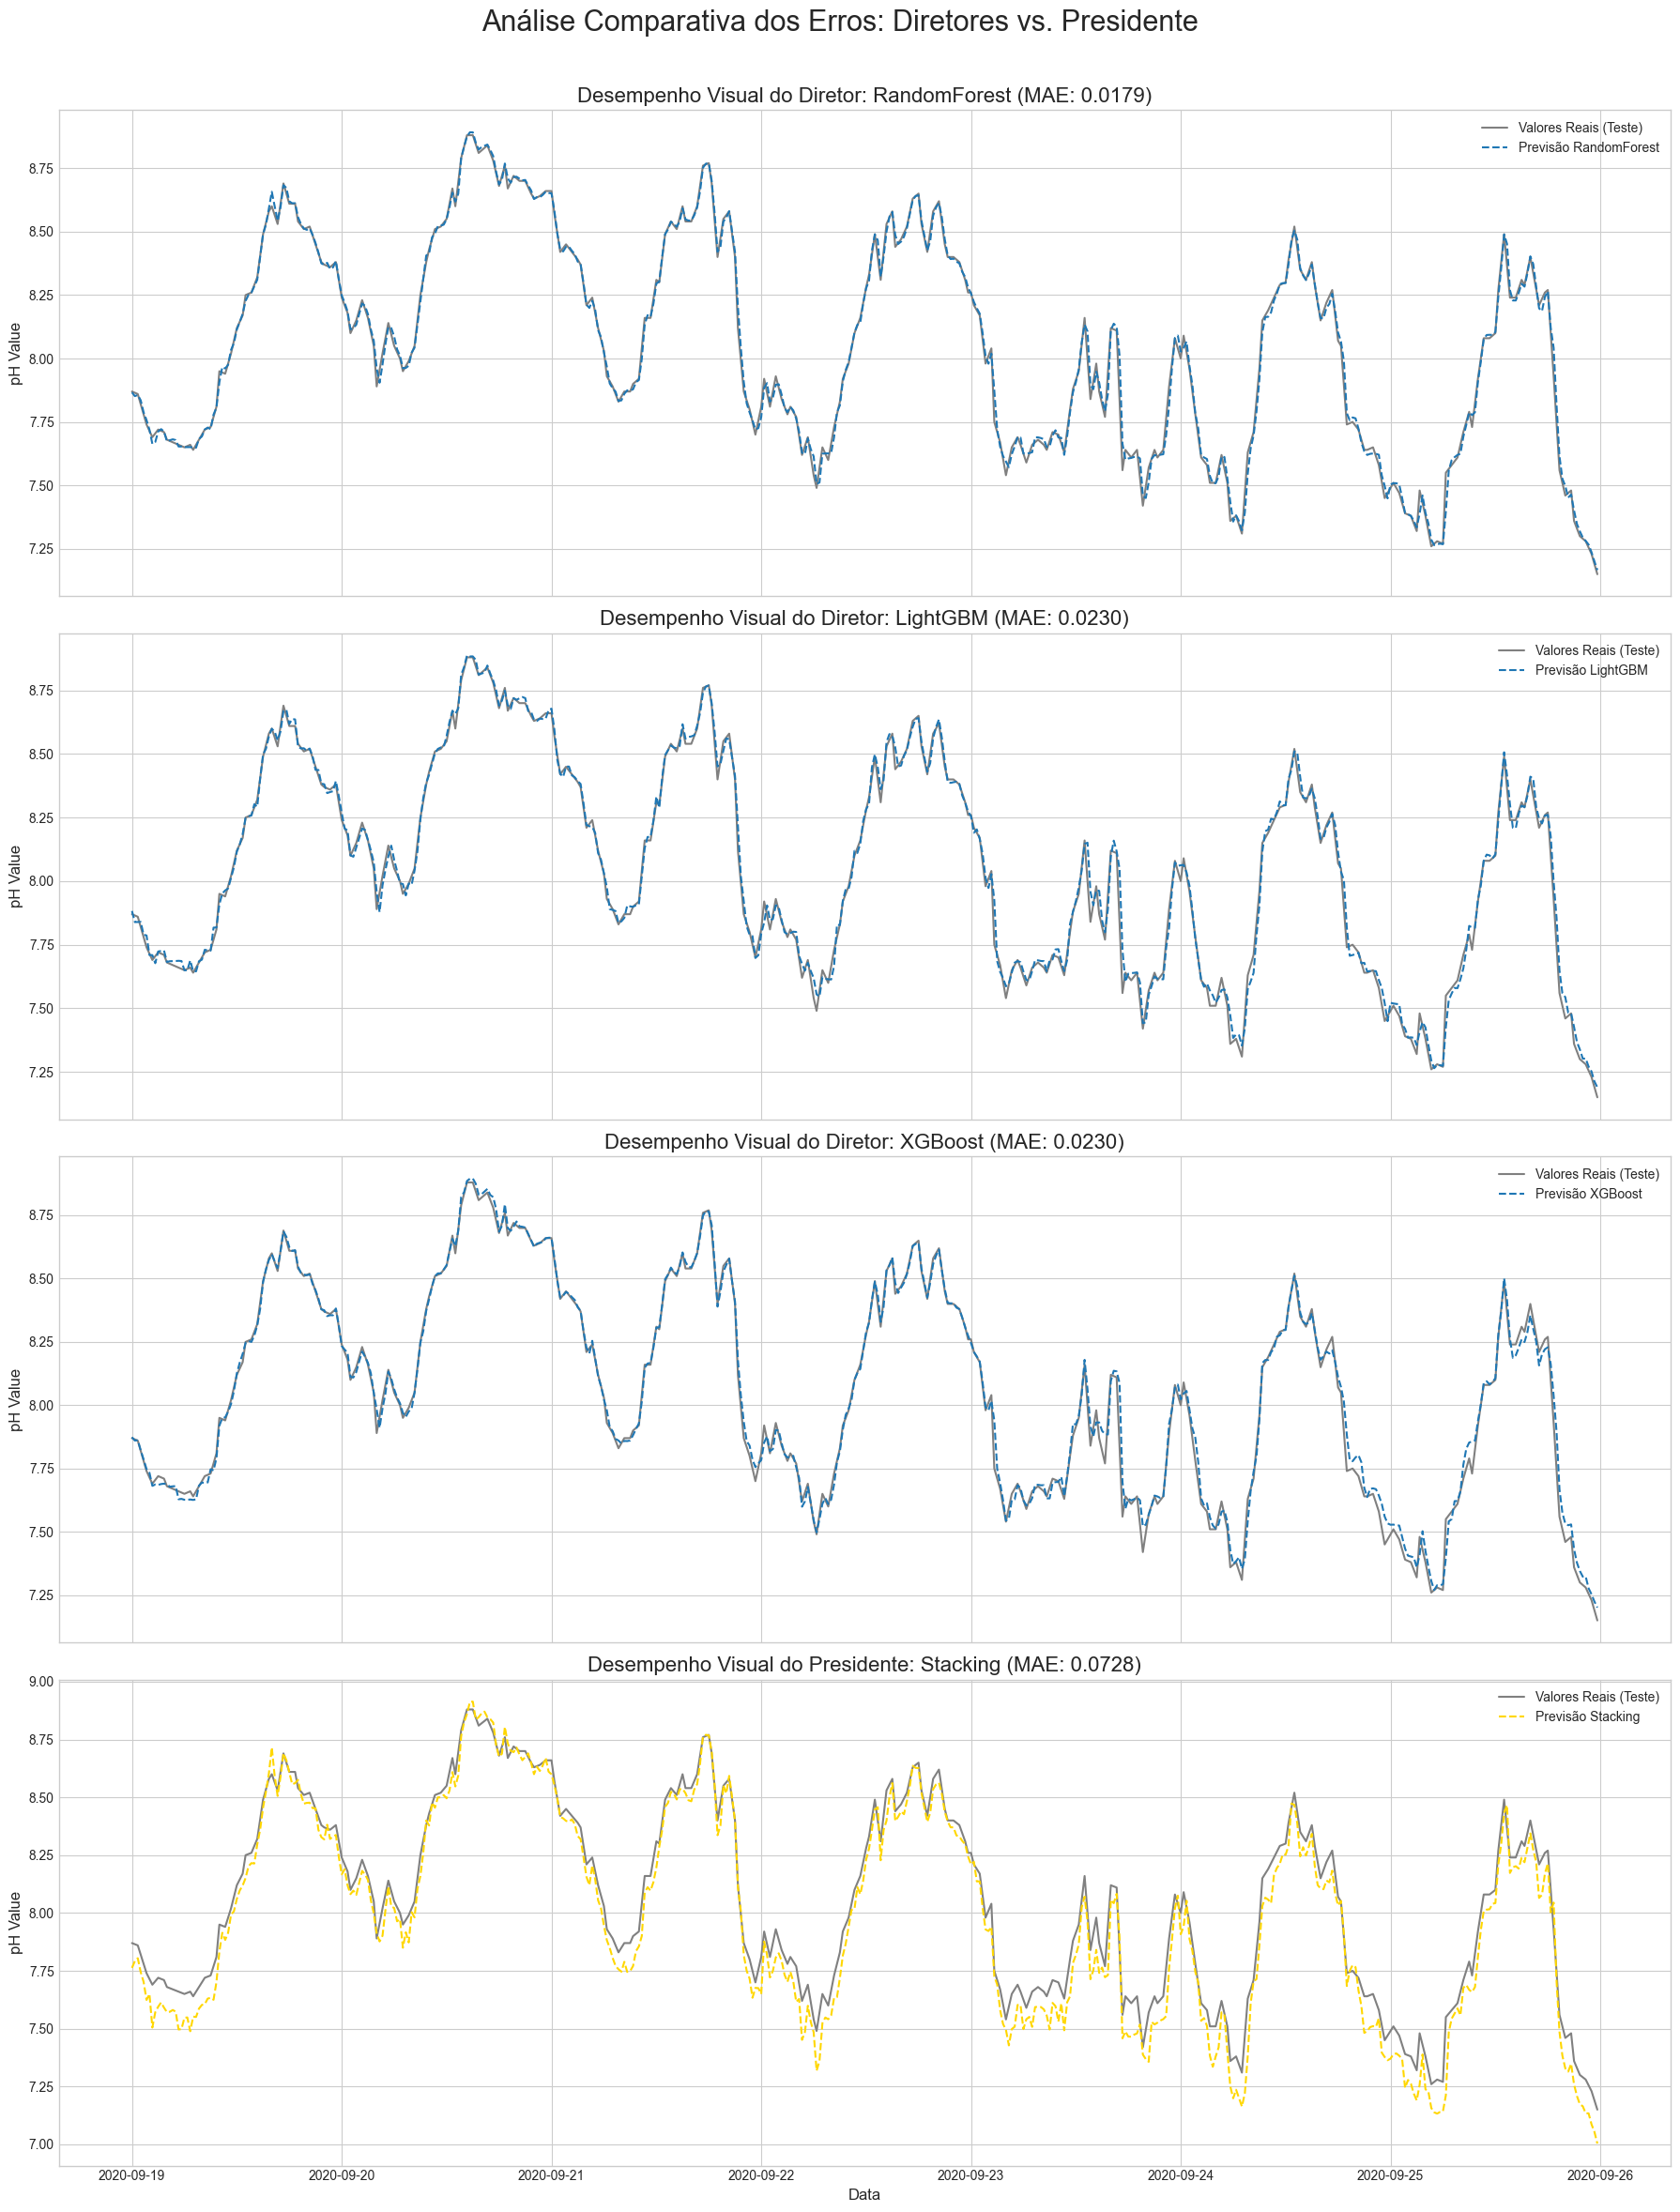

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

df_featured = create_champion_features(df, target_variable='ph')
FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]
train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
print("Dados preparados e divididos.")

# --- 2. Treinar os "Diretores" Individualmente ---
print("\nTreinando os modelos base ('Diretores') individualmente...")
estimators = [
    ('RandomForest', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
    ('LightGBM', lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42, 
                                  learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0)),
    ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, n_jobs=-1, seed=42,
                                 learning_rate=0.05, max_depth=7, subsample=1.0, colsample_bytree=1.0))
]

base_model_predictions = {}
for name, model in estimators:
    print(f"  -> Treinando {name}...")
    if name == 'LightGBM':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(100, verbose=False)])
    elif name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)
    
    prediction = model.predict(X_test)
    base_model_predictions[name] = prediction
    print(f"     MAE ({name}): {mean_absolute_error(y_test, prediction):.4f}")


# --- 3. Treinar o Modelo de Stacking ("Presidente") ---
print("\nIniciando o treinamento do modelo de Stacking ('Presidente')...")
meta_model = Ridge()
cv_stacking = KFold(n_splits=5, shuffle=False)
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model, cv=cv_stacking, n_jobs=-1)
stacking_model.fit(X_train, y_train)
stacking_forecast = stacking_model.predict(X_test)
mae_stacking = mean_absolute_error(y_test, stacking_forecast)
print(f"     MAE (Stacking - Presidente): {mae_stacking:.4f}")

# --- 4. Visualização Comparativa dos Erros ---
print("\nGerando gráficos comparativos...")
plt.style.use('seaborn-v0_8-whitegrid')
n_models = len(estimators) + 1
fig, axes = plt.subplots(n_models, 1, figsize=(18, 6 * n_models), sharex=True)

# Plotar o erro de cada "Diretor"
for i, (name, model) in enumerate(estimators):
    ax = axes[i]
    prediction = base_model_predictions[name]
    mae = mean_absolute_error(y_test, prediction)
    ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray', linewidth=1.5)
    ax.plot(y_test.index, prediction, label=f'Previsão {name}', linestyle='--')
    ax.set_title(f'Desempenho Visual do Diretor: {name} (MAE: {mae:.4f})', fontsize=16)
    ax.set_ylabel('pH Value', fontsize=12)
    ax.legend()

# Plotar o erro do "Presidente"
ax = axes[n_models-1]
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray', linewidth=1.5)
ax.plot(y_test.index, stacking_forecast, label='Previsão Stacking', color='gold', linestyle='--')
ax.set_title(f'Desempenho Visual do Presidente: Stacking (MAE: {mae_stacking:.4f})', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('pH Value', fontsize=12)
ax.legend()

fig.suptitle('Análise Comparativa dos Erros: Diretores vs. Presidente', fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [6]:
# --- Análise dos Coeficientes do Meta-Modelo ("Presidente") ---

# 1. Extrair o meta-modelo treinado (o "Presidente")
meta_model_trained = stacking_model.final_estimator_

# 2. Extrair os nomes dos modelos base ("Diretores") a partir da nossa lista original
base_model_names = [name for name, model in estimators]

# 3. Criar um DataFrame para visualizar os coeficientes de forma clara
coefficients_df = pd.DataFrame({
    'Diretor (Modelo Base)': base_model_names,
    'Peso da Opinião (Coeficiente)': meta_model_trained.coef_
}).sort_values(by='Peso da Opinião (Coeficiente)', ascending=False)

print("--- Pesos Atribuídos pelo 'Presidente' a Cada 'Diretor' ---")
display(coefficients_df)

# Opcional: Visualizar o intercepto do modelo
intercept = meta_model_trained.intercept_
print(f"\nConstante/Intercepto da Regressão do Presidente: {intercept:.4f}")

--- Pesos Atribuídos pelo 'Presidente' a Cada 'Diretor' ---


,Diretor (Modelo Base),Peso da Opinião (Coeficiente)
0,RandomForest,2.293433
2,XGBoost,0.332885
1,LightGBM,-1.544268



Constante/Intercepto da Regressão do Presidente: -0.7231


In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento e Preparação dos Dados (como antes) ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

df_featured = create_champion_features(df, target_variable='ph')
FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]
train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
print("Dados preparados e divididos.")

# --- 2. Definição dos "Diretores" e dos "Presidentes" Candidatos ---
print("\nDefinindo os modelos para a Verificação Ouro...")

# Nossos "Diretores" (modelos base) permanecem os mesmos
estimators = [
    ('RandomForest', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
    ('LightGBM', lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42, 
                                  learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0)),
    ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, n_jobs=-1, seed=42,
                                 learning_rate=0.05, max_depth=7, subsample=1.0, colsample_bytree=1.0))
]

# Nossos "Presidentes" (meta-modelos) candidatos
meta_models_to_test = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'LightGBM_simple': lgb.LGBMRegressor(n_estimators=50, num_leaves=10, n_jobs=-1, verbose=-1, seed=42)
}

# --- 3. Rotina da Verificação Ouro ---
results_list = []
cv_stacking = KFold(n_splits=5, shuffle=False)

print("\n--- Iniciando a Verificação Ouro: Testando Meta-Modelos ---")
start_total_time = time.time()

for name, meta_model in meta_models_to_test.items():
    print(f"\nTestando Presidente: {name}...")
    start_time = time.time()
    
    stacking_model = StackingRegressor(
        estimators=estimators,
        final_estimator=meta_model,
        cv=cv_stacking,
        n_jobs=-1
    )
    
    stacking_model.fit(X_train, y_train)
    stacking_forecast = stacking_model.predict(X_test)
    mae = mean_absolute_error(y_test, stacking_forecast)
    
    end_time = time.time()
    
    results_list.append({
        'Meta-Modelo (Presidente)': name,
        'MAE Final': mae,
        'Tempo de Treino (s)': end_time - start_time
    })
    print(f"  -> MAE Final: {mae:.4f} | Tempo: {end_time - start_time:.2f}s")

end_total_time = time.time()
print(f"\n--- Verificação Ouro Concluída em {end_total_time - start_total_time:.2f} segundos ---")

# --- 4. Análise Final dos Resultados ---
verification_results_df = pd.DataFrame(results_list)
verification_results_df = verification_results_df.sort_values(by='MAE Final', ascending=True).reset_index(drop=True)

print("\n--- Ranking dos Presidentes (Meta-Modelos) ---")
display(verification_results_df)

print("\n--- Melhor Estratégia de Stacking Encontrada ---")
display(verification_results_df.iloc[0])

Carregando e preparando os dados...
Dados preparados e divididos.

Definindo os modelos para a Verificação Ouro...

--- Iniciando a Verificação Ouro: Testando Meta-Modelos ---

Testando Presidente: Ridge...
  -> MAE Final: 0.0728 | Tempo: 32.03s

Testando Presidente: Lasso...
  -> MAE Final: 0.5906 | Tempo: 29.03s

Testando Presidente: SVR...
  -> MAE Final: 0.0687 | Tempo: 29.76s

Testando Presidente: LightGBM_simple...
  -> MAE Final: 0.0453 | Tempo: 34.32s

--- Verificação Ouro Concluída em 125.15 segundos ---

--- Ranking dos Presidentes (Meta-Modelos) ---


C:\Users\User\anaconda3\envs\doc\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Meta-Modelo (Presidente),MAE Final,Tempo de Treino (s)
0,LightGBM_simple,0.045335,34.318361
1,SVR,0.068688,29.764606
2,Ridge,0.072789,32.030895
3,Lasso,0.590603,29.033787



--- Melhor Estratégia de Stacking Encontrada ---


Meta-Modelo (Presidente)    LightGBM_simple
MAE Final                          0.045335
Tempo de Treino (s)               34.318361
Name: 0, dtype: object